<a href="https://colab.research.google.com/github/curry0622/DSAI-HW-2022/blob/master/HW1/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Library

In [170]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

## Data Explore

In [171]:
training_set = pd.read_csv('training_data.csv')
training_set.head()

,日期,淨尖峰供電能力(MW),尖峰負載(MW),備轉容量(MW),備轉容量率(%),工業用電(百萬度),民生用電(百萬度),核一#1(萬瓩),核一#2(萬瓩),核二#1(萬瓩),...,大觀二,明潭,碧海,立霧,龍澗,卓蘭,水里,其他小水力,風力發電,太陽能發電
0,20210101,28487,25720,2767,10.76,311.468,212.061,0,0,98.4,...,50.4,65.6,5.8,1.5,2.4,2.5,0.0,14.9,30.6,0.0
1,20210102,28421,25485,2936,11.52,304.952,207.625,0,0,98.4,...,44.1,71.5,5.5,1.4,3.0,3.0,0.0,18.5,37.0,0.1
2,20210103,28513,25476,3037,11.92,299.771,204.098,0,0,98.4,...,49.3,65.0,5.1,1.4,3.6,0.0,0.0,12.3,48.0,0.0
3,20210104,32766,29734,3032,10.20,342.273,233.036,0,0,98.3,...,46.2,64.6,5.0,1.4,3.0,2.5,0.0,14.9,40.3,0.0
4,20210105,33117,30050,3067,10.21,353.795,240.880,0,0,98.4,...,31.6,48.4,5.8,1.4,3.0,2.5,0.0,21.8,63.0,0.0


## Data Plot

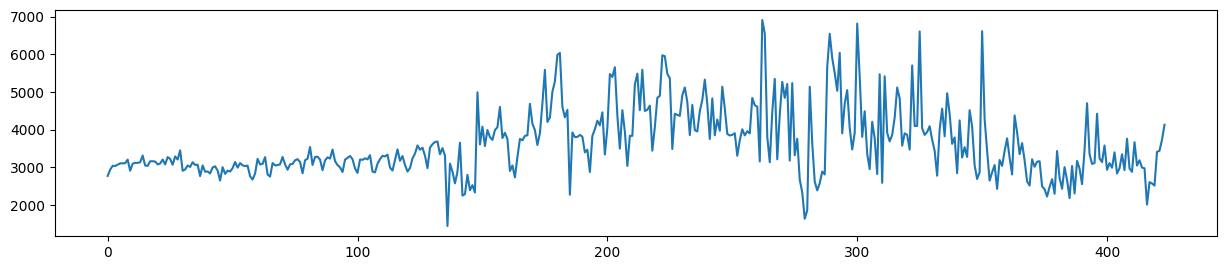

training_set's shape: (424, 1)


In [172]:
training_set = pd.read_csv('training_data.csv')
training_set = training_set.iloc[:,3:4].values

plt.rcParams['figure.figsize'] = [15, 3]
plt.rcParams['figure.dpi'] = 100

plt.plot(
  training_set,
  label='Real Data'
)
plt.show()

print('training_set\'s shape:', training_set.shape)

## Dataloading

In [173]:
def sliding_windows(data, seq_length, pred_length):
    x = []
    y = []

    for i in range(len(data) - seq_length - 1 - pred_length):
        _x = data[i : (i + seq_length)]
        _y = data[i + seq_length : (i + seq_length + pred_length)]

        x.append(_x)
        # y.append(_y)
        y.append(_y.flatten())

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 5
pred_length = 15
x, y = sliding_windows(training_data, seq_length, pred_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

## Model

In [174]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

## Training

[Epoch 0] train loss: 0.28355729579925537, test loss: 0.2905004024505615
[Epoch 100] train loss: 0.023757629096508026, test loss: 0.033668357878923416
[Epoch 200] train loss: 0.01901664398610592, test loss: 0.03282376378774643
[Epoch 300] train loss: 0.017510918900370598, test loss: 0.033904265612363815
[Epoch 400] train loss: 0.017338277772068977, test loss: 0.03430040553212166
[Epoch 500] train loss: 0.017271749675273895, test loss: 0.03437087684869766
[Epoch 600] train loss: 0.017224295064806938, test loss: 0.03439957648515701
[Epoch 700] train loss: 0.017181873321533203, test loss: 0.034417442977428436
[Epoch 800] train loss: 0.01713770069181919, test loss: 0.034425824880599976
[Epoch 900] train loss: 0.01708635687828064, test loss: 0.03442297875881195
[Epoch 1000] train loss: 0.017020851373672485, test loss: 0.034402184188365936
[Epoch 1100] train loss: 0.01692943461239338, test loss: 0.03434547409415245
[Epoch 1200] train loss: 0.016789667308330536, test loss: 0.03421086817979812

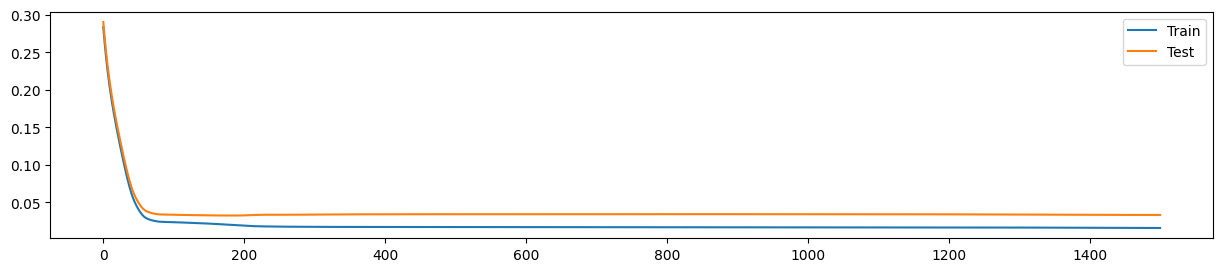

In [175]:
num_epochs = 1500
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = pred_length ############################## initial: 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

train_losses = []
test_losses = []

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()

    with torch.no_grad():
      y_test_pred = lstm(testX)
      test_loss = criterion(y_test_pred, testY)
    test_losses.append(test_loss.item())

    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()

    train_losses.append(loss.item())
    
    optimizer.step()
    if epoch % 100 == 0:
      print(f"[Epoch {epoch}] train loss: {loss.item()}, test loss: {test_loss.item()}")

plt.plot(
  train_losses,
  label='Train'
)
plt.plot(
  test_losses,
  label='Test'
)
plt.legend()

## Random Testing Plot

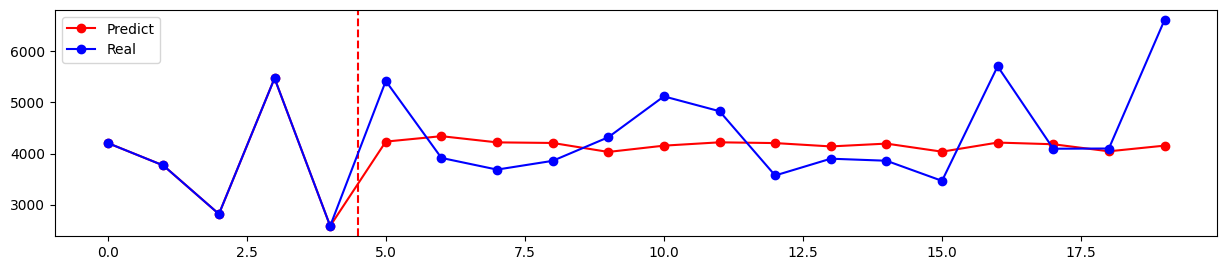

In [176]:
idx = np.random.randint(len(testX))

real_data = np.concatenate((
  testX[idx].data.numpy().flatten(),
  testY[idx].data.numpy().flatten()
))

lstm.eval()
pred_data = lstm(torch.unsqueeze(testX[idx], 0))
pred_data = np.concatenate((
  real_data[:seq_length],
  pred_data.data.numpy().flatten()
))

real_data = sc.inverse_transform(np.expand_dims(
  real_data,
  axis=0
)).flatten()
pred_data = sc.inverse_transform(np.expand_dims(
  pred_data,
  axis=0
)).flatten()

plt.axvline(x=seq_length-0.5, c='r', linestyle='--')
plt.plot(
  pred_data,
  label = 'Predict',
  c='r',
  marker='o'
)
plt.plot(
  real_data,
  label = 'Real',
  c='b',
  marker='o'
)
plt.legend()